# Merge and Clean Data 
### This notebook merges preview and campaign data and performs basic cleaning, geographic preprocessing, text preprocessing, and EDA.

In [49]:
import os
import pandas as pd
import numpy as np
import re
import pickle as pkl
import time

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import geocoder
import geopandas as gpd
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from textblob import TextBlob
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

## 1) Merging Raw Data Frames

In the first step, the raw preview and the raw campaign data frame are merged. They mainly contain text-based data, as these are the raw outputs from the scraper.

In [2]:
# Load data
preview_data = pd.read_pickle('data/raw_preview_data.pkl')
campaign_data = pd.read_pickle('data/raw_campaign_data.pkl')

In [3]:
preview_data.head(3)

,project_link,title,description,card_category,amt_raised,days_left
0,https://www.indiegogo.com/projects/support-fot...,Support FotoNostrum Rising from the Lockdown,"To fully reopen, FotoNostrum needs your help t...",Art,"£34,601 GBP raised 108%",2 days left
1,https://www.indiegogo.com/projects/for-upgrade...,For Upgrade SixTems,Six sisters who grew up planning each others,Art,$615 USD raised 32%,8 hours left
2,https://www.indiegogo.com/projects/oscar-s-pri...,Oscar's Printing Museum Residency,Help fund Oscar's Residency at The Printing Mu...,Art,$125 USD raised 8%,54 days left


In [4]:
campaign_data.head(3)

,story,story_txt,img_len,video_len,campaign_count,campaign_city,url
0,"<div class=""routerContentStory-storyBody"" data...",OUR STORY\r\nWe are building the country's fir...,11.0,0,2 Campaigns\r\n |,"Los Angeles, United States",https://www.indiegogo.com/projects/the-hidden-...
1,"<div class=""routerContentStory-storyBody"" data...",Cirkus in Quarantine: \r\n\r\n\r\nI'm a circus...,0.0,0,2 Campaigns\r\n |,"Brooklyn, United States",https://www.indiegogo.com/projects/cirkus-in-q...
2,"<div class=""routerContentStory-storyBody"" data...",Short Summary\r\nHello again!\r\nWe heard you ...,3.0,0,2 Campaigns\r\n |,"Renton, United States",https://www.indiegogo.com/projects/wagmi-2021-...


In [5]:
# inner join dataframes
raw_data = pd.merge(preview_data, campaign_data, how='inner', left_on='project_link', right_on='url')
raw_data = raw_data.drop(['url', 'project_link', 'story'], axis=1)  # drop url and full html code of campaign
# Final raw data frame
print(raw_data.shape)
raw_data.head(3)

(118605, 10)


,title,description,card_category,amt_raised,days_left,story_txt,img_len,video_len,campaign_count,campaign_city
0,The Hidden History Museum,Help Build The Country's First Museum of Untol...,Art,"$1,187,863 USD raised 111%",NaN,OUR STORY\r\nWe are building the country's fir...,11.0,0,2 Campaigns\r\n |,"Los Angeles, United States"
1,Cirkus in Quarantine: A Book of Live Art,A year of artwork inspired by Circus acts who ...,Art,"$6,612 USD raised 245%",NaN,Cirkus in Quarantine: \r\n\r\n\r\nI'm a circus...,0.0,0,2 Campaigns\r\n |,"Brooklyn, United States"
2,Wagmi 2021 1 oz 999 Silver Round,Raise funding to produce and fulfill custom si...,Art,"$74,826 USD raised 428%",Ended,Short Summary\r\nHello again!\r\nWe heard you ...,3.0,0,2 Campaigns\r\n |,"Renton, United States"


## 2) Basic Data Cleaning

The task for the basic data cleaning section is to convert the columns to more practical types and to derive all necessary variables that are needed for further analysis.

In [6]:
data = raw_data.copy()
data.shape

(118605, 10)

To clean the camapaign_count column, which indicates how many previous campaigns a founder has launched, all values that are not numeric are removed with a regex function. The resulting number can then be converted to an integer.

In [7]:
# Convert campaign_count to int
data['campaign_count'] = data['campaign_count'].apply(lambda x: re.sub('[^0-9]', '', x)) # remove non-numeric characters
data['campaign_count'] = data['campaign_count'].apply(lambda x: int(x)) # convert to int

Almost all rows in the data are campaigns that are already finished, either successfully or unsuccessfully. The ca. 2000 campaigns that are still ongoing are removed from the data.

In [8]:
# Drop campaigns that are not finished
data = data[data['days_left'] == 'Ended'].copy()
data.shape

(116221, 10)

 Around 200 campaigns that had missing values in the campaign title or description were dropped because those were outliers where the campaign creator set up an incomplete campaign. This ensures comparability between campaigns and facilitates the derivation of text features in later steps. In contrast, campaigns with missing values in the story were not erroneous but instead represent a story that only includes images ([Example](https://www.indiegogo.com/projects/ny-yoga-life-mag-issue-2-campaign#/)). Hence, they were kept in the data and imputed by an empty string

In [9]:
# Drop rows without title or description
data = data[~(data[['title', 'description']].isnull()).any(axis=1)].copy()
data.shape

(116018, 10)

In [10]:
# Replace NaN with empty string (no text is accurate representation of campaign. not a scraping error.)
data.loc[data.story_txt.isna(), 'story_txt'] = ''

The amt_raised column is used to extract multiple highly important features. This includes the funding amount, the currency, and the percentage of the funding goal that is reached.

In [11]:
# Clean amt_raised
data = data[~data['amt_raised'].astype(str).str.contains('perks')].copy()  # drop rows where amt_raised is not currency
data['amt_raised_list'] = data['amt_raised'].astype(str).str.split(' ')

data['amt_raised'] = data['amt_raised_list'].str[0]  # extract amount raised
data['currency'] = data['amt_raised_list'].str[1]  # extract currency
data['perc_raised'] = data['amt_raised_list'].str[3]  # extract percentage raised

data = data.drop(['amt_raised_list'], axis=1)  # remove list column

# Replace non-numeric characters and convert to int
data['amt_raised'] = pd.to_numeric(data['amt_raised'].str.replace(r'[\D]', '', regex=True))
data['perc_raised'] = pd.to_numeric(data['perc_raised'].str.replace(r'[\D]', '', regex=True))

# Remove rows where extraction failed
data['amt_raised'] = data['amt_raised'].replace([np.inf, -np.inf], np.nan) # convert inf to nan
print('Removing {} obs where extraction resulted in NaN or inf'.format(data['amt_raised'].isna().sum()))
data = data[~data['amt_raised'].isnull()].copy()

# Convert to int
data['amt_raised'] = data['amt_raised'].astype(int)
data['perc_raised'] = data['perc_raised'].astype(int)

Removing 145 obs where extraction resulted in NaN or inf


All funding amounts were converted to dollar equivalents, using exchange rates from yahoo finance. 

In [12]:
# Convert to dollar equivalents   # rates from https://finance.yahoo.com/  (24.11.2021)
print(data.currency.value_counts())

exchange_rates = {
    'USD': 1,
    'EUR': 1.12,
    'GBP': 1.33,
    'CAD': 0.79,
    'AUD': 0.72,
    'HKD': 0.13,
    'SGD': 0.73,
    'JPY': 0.0087,
}

for c in exchange_rates.keys():
    data.loc[data.currency == c, 'amt_raised'] = data.loc[data.currency == c, 'amt_raised'] * exchange_rates[c]

USD    93556
EUR     7747
GBP     6926
CAD     5837
AUD     1322
HKD      340
SGD      112
JPY       33
Name: currency, dtype: int64


Now, the original funding goal and a binary success variable can be derived. 

In [13]:
# Infer funding goal
data['fnd_goal'] = data['amt_raised'] / (data['perc_raised']/100)
data['fnd_success'] = np.where(data['perc_raised'] >= 100, 1, 0)    
data['fnd_goal'] = data['fnd_goal'].replace([np.inf, -np.inf], np.nan) # convert inf to nan

The piechart below shows the skewed distribution of funding success, with only about 20% of campaigns achieving their funding goal.

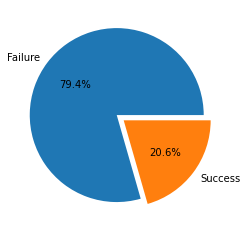

In [14]:
# Piechart fnd_success
fig, ax = plt.subplots(figsize=(4,4))
# plot piechart
ax.pie(data['fnd_success'].value_counts(), labels=['Failure', 'Success'], explode = (0, 0.1), autopct='%1.1f%%')
plt.show()

Infer the "supercategory" or "sector" from the category that is present in the data.

In [17]:
# Infer supercategory
tech_innovation = ["Audio", "Camera Gear", "Education", "Energy & Green Tech", "Fashion & Wearables", "Food & Beverages", 
                    "Health & Fitness", "Home", "Phones & Accessories", "Productivity", "Transportation", "Travel & Outdoors"]
creative_works = ["Art", "Comics", "Dance & Theater", "Film", "Music", "Photography", "Podcasts, Blogs & Vlogs",
                  "Tabletop Games", "Video Games", "Web Series & TV Shows", "Writing & Publishing"]
community_projects = ["Culture", "Environment", "Human Rights", "Local Businesses", "Wellness"]

data['supercategory'] = np.where(data['card_category'].isin(tech_innovation), 'tech_innovation',
                            np.where(data['card_category'].isin(creative_works), 'creative_works', 
                                np.where(data['card_category'].isin(community_projects), 'community_projects', 'other')))

Rename columns for more consistent naming and intuitive plotting later on.

In [18]:
# Rename columns
data = data.rename(columns={'card_category': 'category',
                            'amt_raised': 'fnd_raised',
                            'perc_raised': 'fnd_perc',
                            'img_len': 'images',
                            'video_len': 'videos'})

## 3) Geoencode and cluster geographic data

Cleaning and geocoding the address column required multiple steps. It starts by simply making use of the uniform formatting and splitting the addresses into the city and country part, based on the comma in the string formatting.

In [19]:
# Clean city column / location
print(data.shape)
data = data[~data.campaign_city.isna()]  # Drop obs where city/country is missing
data = data[data['campaign_city'].str.contains(', ')] # Drop obs where city/country is missing or not in correct format
print(data.shape)

# Split location column into city and country
data['campaign_city_list'] = data['campaign_city'].apply(lambda x: x.split(', '))
data['country'] = data['campaign_city_list'].apply(lambda x: x[1])
data['city'] = data['campaign_city_list'].apply(lambda x: x[:-1][0])

data = data.drop('campaign_city_list', axis=1)

(115873, 15)
(115450, 15)


I am mainly interested in the USA campaigns as they constitute the largest part of the data. However, many campaigns list a US state as their country in a format like "New York, NY". To also classify these campaigns as US campaigns, a dictionary of all US states and their abbreviations is loaded. The abbreviations are augmented, by e.g. removing the punctuations so "N.Y." and "NY" would both be captured as "NY". All states and abbreviations were converted to "United States" to match all other campaigns from the US.

In [20]:
# Convert states and abbreviations to 'United States'
states = pd.read_csv('data/US_states.csv')
# Create additional forms of abbreviations (All corresponding to 'United States')
states['not_punct'] = states.Abbrev.apply(lambda x: x.replace('.', ''))
states['code_upper_lower'] = states.Code.apply(lambda x: x.replace(x[1], x[1].lower())) # convert 2nd letter to lower
states['code_lower'] = states.Code.apply(lambda x: x.lower())
states = states.values.flatten()  # convert to list
states = np.append(states, ['USA', 'US', 'NYC', 'New York City']) # add custom states

nrUS1 = sum(data.country=='United States')
data['country'] = data['country'].apply(lambda x: 'United States' if x in states else x)
nrUS2 = sum(data.country=='United States')
print('Converted {} obs to "United States"'.format(nrUS2 - nrUS1))

Converted 834 obs to "United States"


The following plot visualizes the dominance of the US in the data.

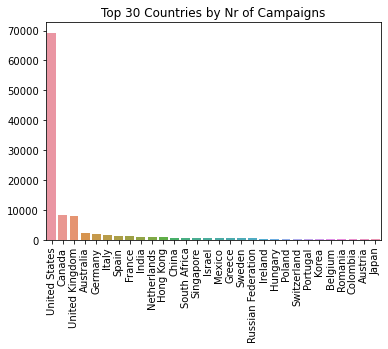

In [21]:
# plot countplot countries
country_plot = data.country.value_counts()[0:30]
sns.barplot(x = country_plot.index, y=country_plot.values)
plt.xticks(rotation=90)
plt.title('Top 30 Countries by Nr of Campaigns')
plt.show()

To create a homogeneous data set. The subsequent analysis is focused only on campaigns from the US.

In [22]:
# only keep US campaigns
data = data.loc[data.country == 'United States', :]
data.shape

(69290, 17)

The next part is concerned with the geocoding of the addresses, in order to get a longitude and latitude value for each campaign. For this the Google Maps API is used, which can convert address strings into a json file with all the necessary information. However, the API is a paid service with only a limited number of free calls, so calling the API once for each data point and with each run of the script should be avoided. Instead, I create a dictionary for each unique address, that can be saved locally. This also ensures reproducibility, as the private API keys are not needed to rerun the script.

In [23]:
# Geoencode addresses
def create_geo_dict(address_list):
    ''' Encode list of addresses with google API and geocoder '''
    call_api = input('Make {} API calls for ${}? (y/n): '.format(len(address_list), len(address_list)*0.005)) # $200 credit
    if call_api == 'y':
        geocoder_results = []  # list of geocoder objects
        # Geo-code addresses
        for i, address in enumerate(address_list):
            print('- Geocode address ({}/{}): {}'.format(i+1, len(address_list), address))
            result = geocoder.google(address, key=os.environ['GMAPS_API_KEY'], rate_limit=False)
            result = result.json
            geocoder_results.append(result)
            time.sleep(0.1)

        geo_dict = dict(zip(address_list, geocoder_results))
        return geo_dict

    else:
        print('Aborted. Returning None')
        return None

In [24]:
# Geocode US addresses
address_list = data.campaign_city.unique()
print('Nr addresses:', len(address_list))
print(address_list[:5])

Nr addresses: 7880
['Renton, United States' 'Charleston, United States'
 'Philadelphia, United States' 'Crestone, United States'
 'Petaluma, United States']


The following code can either create a new geo dictionary or load an existing one from the data folder. Creating a new dictionary however will fail without supplying the necessary API key in the function above.

In [25]:
# Create dictionary of geocoder objects (avoids API calls everytime the script is run)
create_geodict = False

if create_geodict:
    geo_dict = create_geo_dict(address_list)  # create dictionary that maps address to geocode object
    with open('data/geo_dict.pkl', 'wb') as file:
        pkl.dump(geo_dict, file)
else:
    print('Loaded existing geo_dict')
    with open('data/geo_dict.pkl', 'rb') as file:  # load existing dictionary
        geo_dict = pkl.load(file)

Loaded existing geo_dict


By mapping the finished dictionary to the address column, a new column of google geo objects is created, from which all necessary information can be extracted by simple lambda functions.

In [26]:
# Map geocoder results to dataframe
data['geo_col'] = data['campaign_city'].map(geo_dict).copy()

# Drop columsn with failed conversions
data = data.dropna(subset=['geo_col']).copy()

# Exctract info from geocoder object
data['city_geo'] = data['geo_col'].apply(lambda x: x.get('city'))
data['country_geo'] = data['geo_col'].apply(lambda x: x.get('country'))
data['state'] = data['geo_col'].apply(lambda x: x.get('state'))
data['lng'] = data['geo_col'].apply(lambda x: x.get('lng'))
data['lat'] = data['geo_col'].apply(lambda x: x.get('lat'))

# Correct state names
data['state'] = data['state'].replace('California', 'CA')
data['state'] = data['state'].replace('New Mexico', 'NM')

# Drop rows with failed conversions
data = data[data.country_geo == 'US']
data = data[data.state.notnull()]

# Drop original campaign_city column
data = data.drop(columns=['campaign_city'])
data.shape

(68767, 22)

With these coordinates, Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is used to segment the data into multiple high-density clusters and one low-density cluster. From this, a new "urban" variable is constructed where each point that belongs to a high-density cluster has the value 1 and has 0 otherwise.

(-130.0, -65.0)

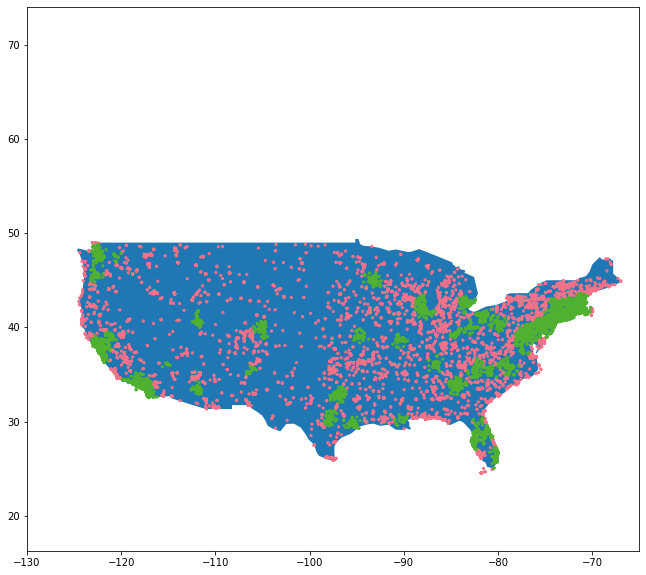

In [27]:
# DBSCAN clustering of longitude and latitute
X = data[['lng', 'lat']]
data['clusters_db'] = DBSCAN(eps=0.6, min_samples=300).fit_predict(X)
data['urban'] = np.where(data['clusters_db'] == -1, 0, 1) # create rural binary var for later analysis

# Set corresponding colors for each cluster
colors = sns.color_palette("husl", 3)
data['color'] = data['urban'].map(lambda x: colors[x])

# plot with geopandas
geometry = gpd.points_from_xy(data['lng'], data['lat'])
gdf = gpd.GeoDataFrame(data, geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world.name == "United States of America"]
gdf.plot(ax=usa.plot(figsize=(15, 10)), marker='o', color=data.color, markersize=5).set_xlim(-130, -65)

In the last step of the geographic preprocessing the economic data on a state level can be merged to the data frame. 

In [28]:
# Load venture capital and GDP data per state
state_data = pd.read_excel('data/VC_index.xlsx', skiprows=range(1,5) ,nrows=51, usecols = 'A, Z, AZ, BZ')
state_data.columns = ['state', 'VC', 'GDP', 'VC_per_GDP']

# Load state names and abbreviation
states = pd.read_csv('data/US_states.csv')
state_dict = dict(zip(states.State, states.Code))

# Convert long names to abbreviations
state_data['state'] = state_data['state'].map(state_dict)

# Join state data to original df
data = pd.merge(data, state_data, how='left', on='state')

## 4) Text preprocessing

Preprocessing the text data is a relatively straightforward process, as the procedure is the same for all text columns, i.e. the title, description, and story. It starts with basic text cleaning, i.e., removing stop words, special characters, numbers, and converting all words to lower case as specified in the function below.

In [29]:
def clean_texts(text_col):
    print("Cleaning {}...".format(text_col.name))

    # define stop words
    stop_words = set(stopwords.words('english'))
    #stop_words.update(('stop1', 'stop2')) # add custom stop words

    text_col = text_col.apply(lambda x: re.sub('[^A-Za-z ]+', ' ', x))  # remove special characters and numbers
    text_col = text_col.apply(lambda x: x.lower())  # convert to lower

    words = text_col.apply(lambda x: [w for w in word_tokenize(x)])  # splits text_col into words
    words = words.apply(lambda x: [w for w in x if w not in stop_words])  # remove stopwords
    # tokens = tokens.apply(lambda x: [WordNetLemmatizer().lemmatize(t) for t in x])  # lemmatize words
    text_col = words.apply(lambda x: ' '.join(x))  # join words back together

    # text_col = text_col.apply(lambda x: re.sub(r"\b[a-zA-Z]\b", "", x))  # remove all single letters
    return text_col

In [30]:
data['title_clean'] = clean_texts(data['title'])
data['description_clean'] = clean_texts(data['description'])
data['story_txt_clean'] = clean_texts(data['story_txt'])

Cleaning title...
Cleaning description...
Cleaning story_txt...


Then the TextBlob library is used to calculate a polarity and subjectivity score. The former measures the sentiment of a text, whereas the latter quantifies how emotionally a text is written. Lastly, the word count of each title, description, and story is calculated. The libray employs a dictionary-based approach, where each word is matched against a dictionary that has words with positive/negative sentiment and high/low emotion. The final score is then an average over all words in the text sample that is evaluated.

In [31]:
# Get sentiment of title
data['title_pol'] = data['title_clean'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['title_sub'] = data['title_clean'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
# Get sentiment of description
data['description_pol'] = data['description_clean'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['description_sub'] = data['description_clean'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
# Get sentiment of entire text
data['story_txt_pol'] = data['story_txt_clean'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['story_txt_sub'] = data['story_txt_clean'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [32]:
# Calculate length of each section
data['title_len'] = data['title'].apply(lambda x: len(x.split()))
data['description_len'] = data['description'].apply(lambda x: len(x.split()))
data['story_txt_len'] = data['story_txt'].apply(lambda x: len(x.split()))

With the text processing, the data derivation and cleaning part is concluded and the final data is saved as a pickle file.

In [33]:
data.to_pickle('data/final_data.pkl')

### 5) EDA

This section conducts broad exploratory data analysis that was used to familiarize myself with the data and potentially uncover some interesting patterns. Not every graphic is 100% directed towards answering the final research question. Nonetheless, I left many plots in the notebook to show my thinking when I tried to look at the data from different angles during the first investigation.

First, the summary stats of each variable can be looked at with the describe function.
We can instantly see the e.g. the average funding amount of $17'567, but only succeedes with a 20% likelihood.
Also that the average campaign uses 5 images, no videos and 700 words to describe their campaign.

In [40]:
sumstats = data.describe().round(2)  
sumstats

,fnd_raised,images,videos,campaign_count,fnd_perc,fnd_goal,fnd_success,lng,lat,clusters_db,...,VC_per_GDP,title_pol,title_sub,description_pol,description_sub,story_txt_pol,story_txt_sub,title_len,description_len,story_txt_len
count,68767.00,68767.00,68767.00,68767.00,68767.00,61708.00,68767.00,68767.00,68767.00,68767.00,...,68767.00,68767.00,68767.00,68767.00,68767.00,68767.00,68767.00,68767.00,68767.00,68767.00
mean,17567.31,5.16,0.23,1.75,545.98,15693.47,0.21,-95.62,38.14,6.20,...,8216.35,0.05,0.15,0.12,0.31,0.16,0.45,5.39,14.95,699.53
std,163352.16,10.79,0.91,3.03,95440.44,54638.65,0.41,19.65,5.16,8.01,...,7713.61,0.18,0.27,0.23,0.30,0.09,0.10,2.38,5.99,555.70
min,0.00,0.00,0.00,0.00,0.00,1.03,0.00,-168.09,18.99,-1.00,...,1.92,-1.00,0.00,-1.00,0.00,-1.00,0.00,1.00,1.00,0.00
25%,260.00,0.00,0.00,1.00,4.00,2500.00,0.00,-118.24,34.05,1.00,...,2096.97,0.00,0.00,0.00,0.00,0.11,0.41,4.00,11.00,348.00
50%,1030.00,0.00,0.00,1.00,21.00,5495.02,0.00,-88.11,39.07,2.00,...,4477.38,0.00,0.00,0.00,0.30,0.16,0.46,5.00,15.00,567.00
75%,3415.00,5.00,0.00,2.00,73.00,14981.07,0.00,-77.04,41.20,9.00,...,9569.11,0.00,0.23,0.24,0.50,0.21,0.51,7.00,18.00,899.00
max,13702534.00,146.00,36.00,234.00,24833100.00,8013036.51,1.00,-66.99,70.23,33.00,...,21138.46,1.00,1.00,1.00,1.00,1.00,1.00,18.00,37.00,10987.00


These graphs show how different variables are distributed for successful vs unsuccessful campaigns.
The biggest shift differences are as expected in the funding amount that was raised. Unsuccessful campaigns also have a higher funding goal on average, use fwewer images and videos, and have shorter stories.

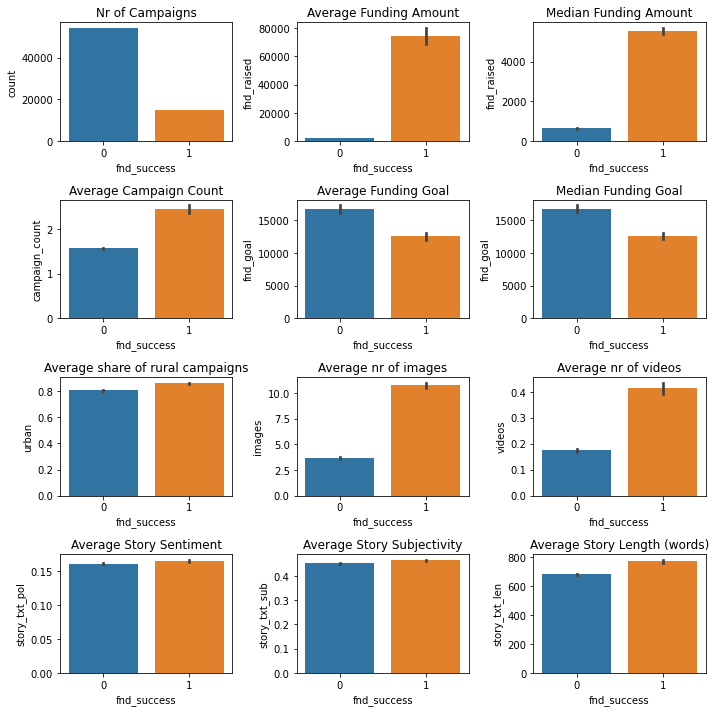

In [41]:
data['fnd_goal_bin'] = pd.cut(data['fnd_goal'], bins=range(0,1000001,100000), labels=[f'{l}-{l+10}' for l in range(0,900001,100000)])

fig, axs = plt.subplots(4, 3, figsize=(10, 10))
sns.countplot(ax=axs[0, 0], x='fnd_success', data=data).set_title('Nr of Campaigns')
sns.barplot(ax=axs[0, 1], x='fnd_success', y='fnd_raised', data=data, estimator=np.mean).set_title('Average Funding Amount')
sns.barplot(ax=axs[0, 2], x='fnd_success', y='fnd_raised', data=data, estimator=np.median).set_title('Median Funding Amount')

sns.barplot(ax=axs[1, 0], x='fnd_success', y='campaign_count', data=data, estimator=np.mean).set_title('Average Campaign Count')
sns.barplot(ax=axs[1, 1], x='fnd_success', y='fnd_goal', data=data).set_title('Average Funding Goal')
sns.barplot(ax=axs[1, 2], x='fnd_success', y='fnd_goal', data=data, estimator=np.mean).set_title('Median Funding Goal')

sns.barplot(ax=axs[2, 0], x='fnd_success', y='urban', data=data, estimator=np.mean).set_title('Average share of rural campaigns')
sns.barplot(ax=axs[2, 1], x='fnd_success', y='images', data=data, estimator=np.mean).set_title('Average nr of images')
sns.barplot(ax=axs[2, 2], x='fnd_success', y='videos', data=data, estimator=np.mean).set_title('Average nr of videos')

sns.barplot(ax=axs[3, 0], x='fnd_success', y='story_txt_pol', data=data, estimator=np.mean).set_title('Average Story Sentiment')
sns.barplot(ax=axs[3, 1], x='fnd_success', y='story_txt_sub', data=data, estimator=np.mean).set_title('Average Story Subjectivity')
sns.barplot(ax=axs[3, 2], x='fnd_success', y='story_txt_len', data=data, estimator=np.mean).set_title('Average Story Length (words)')

plt.tight_layout()
plt.show()

The following figure shows the number of campaigns in each sector and category.
One can quickly see that the creative works sector has the most campaigns and that the most popular campaign category is dance and theater. Overall the popularity of different categories varies a lot.

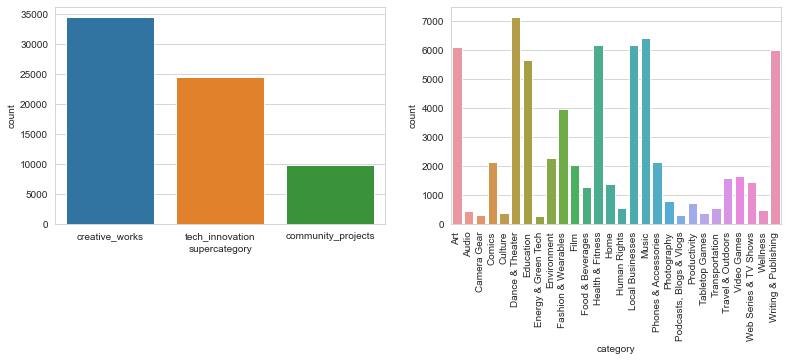

In [51]:
# Countplot supercategory
fig, axs = plt.subplots(1, 2, figsize=(13,4))
sns.countplot(ax=axs[0], x='supercategory', data=data)
sns.countplot(ax=axs[1], x='category', data=data)
# rotate x tick labels ax=axs[1]
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
plt.show()

This plot is a nice visualization of market size and funding success per category and sector.
One can see that market size and success rates depend a lot on sector and category. Especially the technology sector raises the most funds. Average success rates are more equal across categories than market size.

C:\Users\stefan\AppData\Local\Temp/ipykernel_1356/608503598.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(yticks)


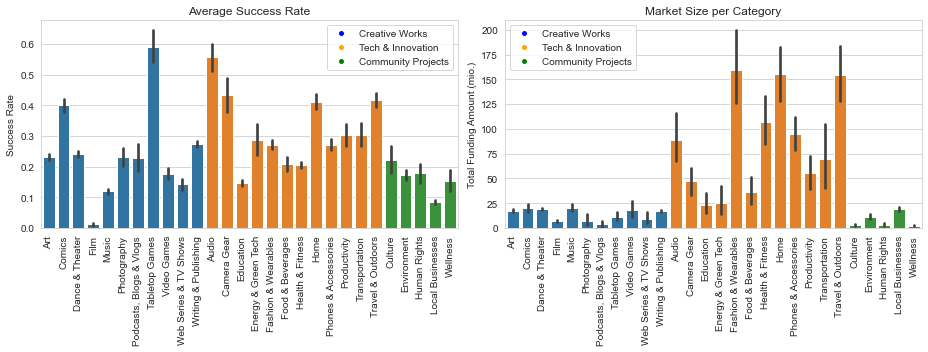

In [43]:
# create list of supercategories
creative_works = ["Art", "Comics", "Dance & Theater", "Film", "Music", "Photography", "Podcasts, Blogs & Vlogs",
                  "Tabletop Games", "Video Games", "Web Series & TV Shows", "Writing & Publishing"]
tech_innovation = ["Audio", "Camera Gear", "Education", "Energy & Green Tech", "Fashion & Wearables", "Food & Beverages", 
                    "Health & Fitness", "Home", "Phones & Accessories", "Productivity", "Transportation", "Travel & Outdoors"]
community_projects = ["Culture", "Environment", "Human Rights", "Local Businesses", "Wellness"]
supercategories = creative_works + tech_innovation + community_projects

# create list of colors
colors = ['tab:blue'] * len(creative_works) + ['tab:orange'] * len(tech_innovation) + ['tab:green'] * len(community_projects)

# plot
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

sns.barplot(ax=axs[0], x='category', y='fnd_success', data=data, order=supercategories, palette=colors, estimator=np.mean)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_xlabel('')
axs[0].set_ylabel('Success Rate')
axs[0].set_title('Average Success Rate')

sns.barplot(ax=axs[1], x='category', y='fnd_raised', data=data, order=supercategories, palette=colors, estimator=np.sum)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].set_xlabel('')
axs[1].set_ylabel('Total Funding Amount (mio.)')
axs[1].set_title('Market Size per Category')
# convert yticks to millions
yticks = axs[1].get_yticks()
yticks = [int(y/1000000) for y in yticks]
axs[1].set_yticklabels(yticks)


# add custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w',markerfacecolor='b'),
                   Line2D([0], [0], marker='o', color='w',markerfacecolor='orange'),
                   Line2D([0], [0], marker='o', color='w',markerfacecolor='g')]
axs[0].legend(legend_elements, ["Creative Works", "Tech & Innovation", "Community Projects"], loc='upper right')
axs[1].legend(legend_elements, ["Creative Works", "Tech & Innovation", "Community Projects"], loc='upper left')

plt.tight_layout()
plt.show()

The following graph looks at potential patterns of other variables across categories. Funding amounts and success rates differ a lot across categories, however, the largest markets are not necessarily those with the highest success rate. Tabletop games and comics stand out, as those categories where fundraisers launch the most number of campaigns on average. Audio and Camera Gear have the highest number of images and videos used in the stories.

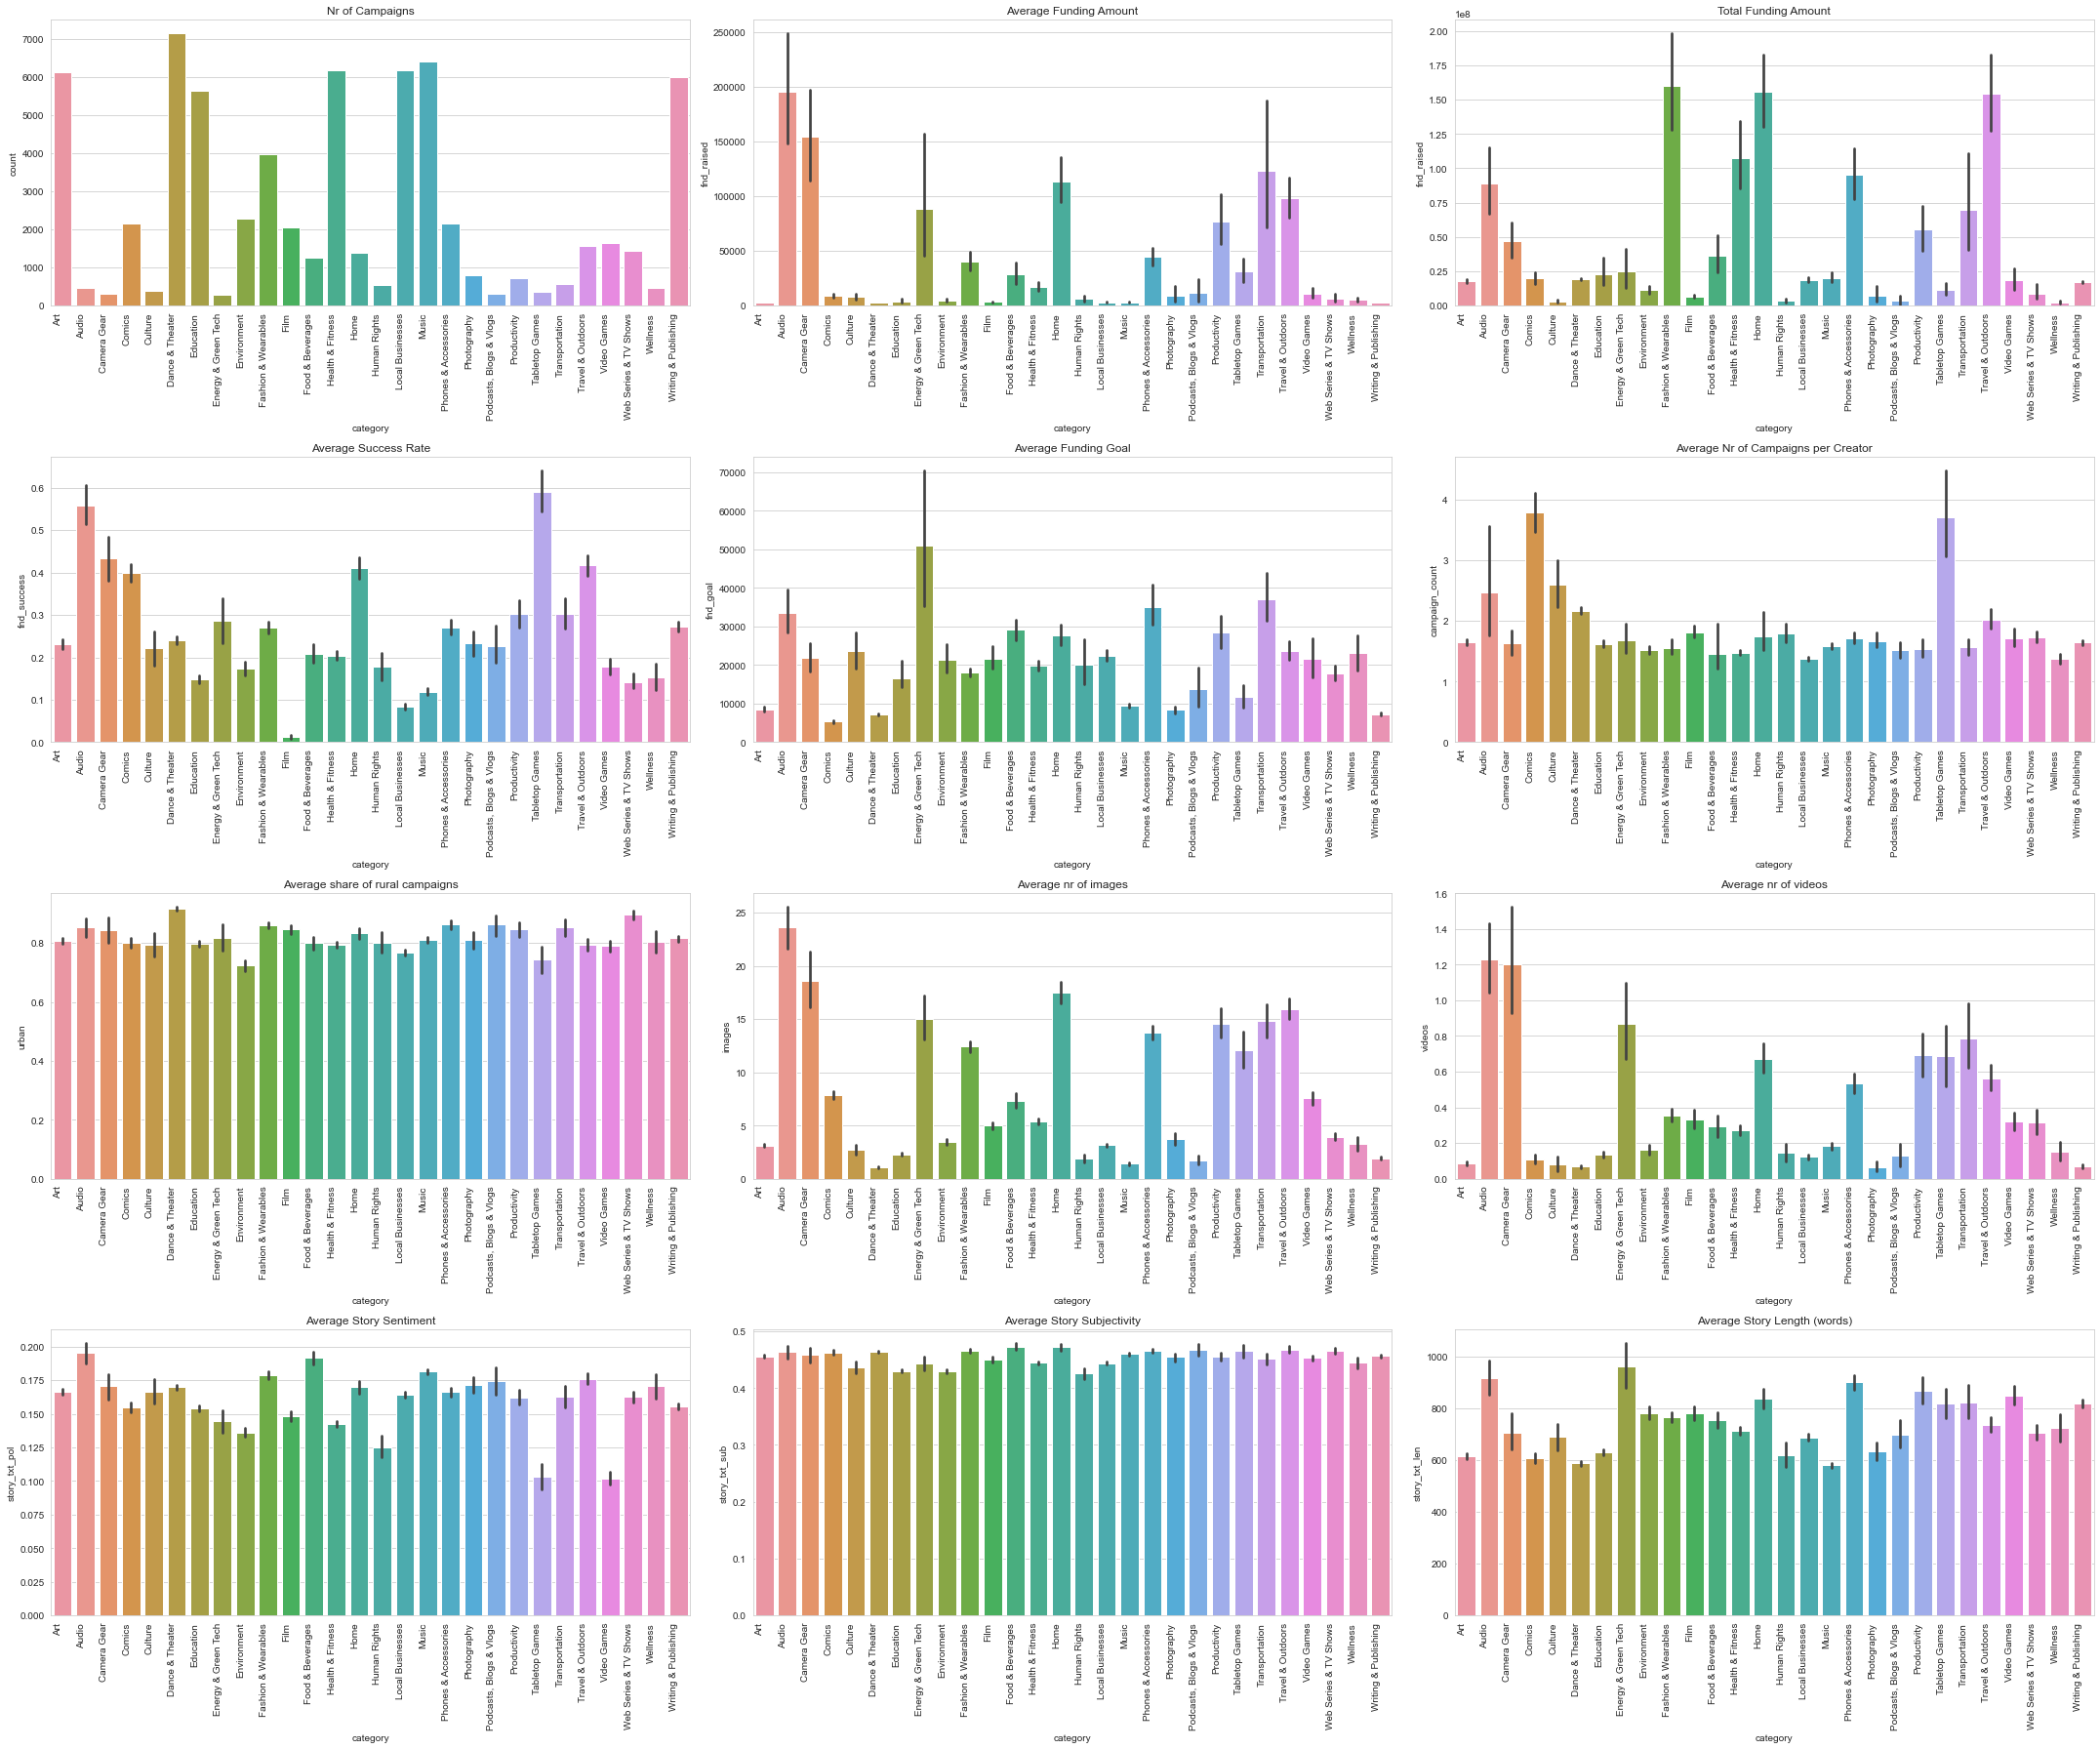

In [44]:
fig, axs = plt.subplots(4, 3, figsize=(30, 25))

sns.countplot(ax=axs[0, 0], x='category', data=data).set_title('Nr of Campaigns')
sns.barplot(ax=axs[0, 1], x='category', y='fnd_raised', data=data, estimator=np.mean).set_title('Average Funding Amount')
sns.barplot(ax=axs[0, 2], x='category', y='fnd_raised', data=data, estimator=np.sum).set_title('Total Funding Amount')

sns.barplot(ax=axs[1, 0], x='category', y='fnd_success', data=data, estimator=np.mean).set_title('Average Success Rate')
sns.barplot(ax=axs[1, 1], x='category', y='fnd_goal', data=data, estimator=np.mean).set_title('Average Funding Goal')
sns.barplot(ax=axs[1, 2], x='category', y='campaign_count', data=data, estimator=np.mean).set_title('Average Nr of Campaigns per Creator')

sns.barplot(ax=axs[2, 0], x='category', y='urban', data=data, estimator=np.mean).set_title('Average share of rural campaigns')
sns.barplot(ax=axs[2, 1], x='category', y='images', data=data, estimator=np.mean).set_title('Average nr of images')
sns.barplot(ax=axs[2, 2], x='category', y='videos', data=data, estimator=np.mean).set_title('Average nr of videos')

sns.barplot(ax=axs[3, 0], x='category', y='story_txt_pol', data=data, estimator=np.mean).set_title('Average Story Sentiment')
sns.barplot(ax=axs[3, 1], x='category', y='story_txt_sub', data=data, estimator=np.mean).set_title('Average Story Subjectivity')
sns.barplot(ax=axs[3, 2], x='category', y='story_txt_len', data=data, estimator=np.mean).set_title('Average Story Length (words)')


# rotate all x-labels
for ax in axs.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

The following plots different variables by US state. Most campaigns are launched in CA and NY, and also have the largest venture capital investments. DE and UT have the highest success rates, however, this might not be a robust result due to the low number of campaigns in these states.

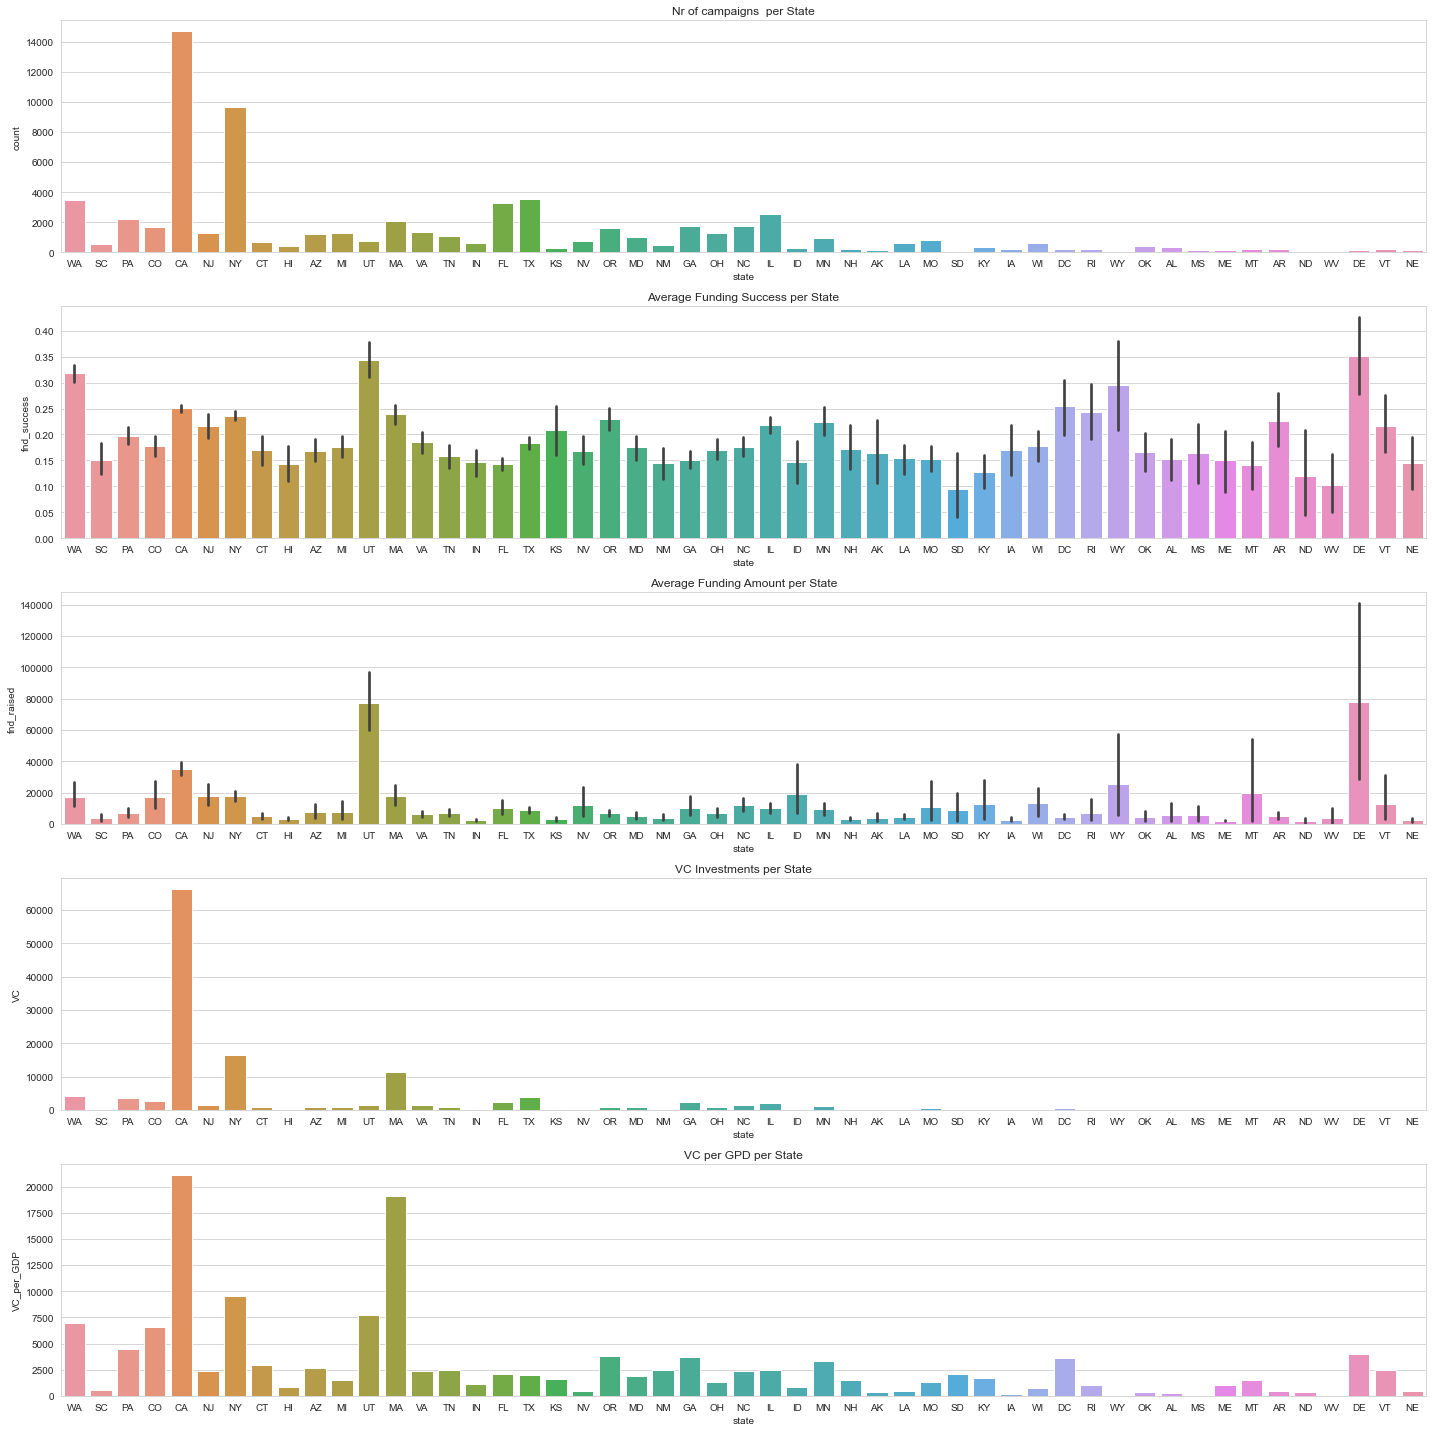

In [45]:
fig, axs = plt.subplots(5, 1, figsize=(20, 20))
sns.countplot(ax=axs[0], x='state', data=data).set_title('Nr of campaigns  per State')
sns.barplot(ax=axs[1], x='state', y='fnd_success', data=data, estimator=np.mean).set_title('Average Funding Success per State')
sns.barplot(ax=axs[2], x='state', y='fnd_raised', data=data, estimator=np.mean).set_title('Average Funding Amount per State')
sns.barplot(ax=axs[3], x='state', y='VC', data=data, estimator=np.mean).set_title('VC Investments per State')
sns.barplot(ax=axs[4], x='state', y='VC_per_GDP', data=data, estimator=np.mean).set_title('VC per GPD per State')

plt.tight_layout()
plt.show()

This plot shows the distribution of campaigns that are typically done by a fundraiser, as well as the average success likelihood by nr. of campaigns. It seems like the more often a creator launches a crowdfunding project the more successful it gets. This might be due to survivorship bias, however.

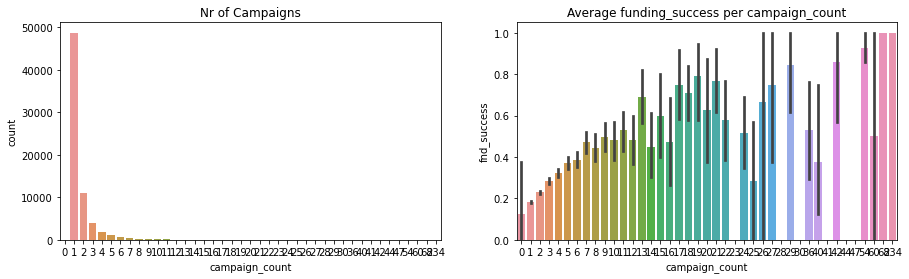

In [35]:
# plot funding_success vs campaign_count
fig, axs = plt.subplots(1, 2, figsize=(15,4))
sns.countplot(ax=axs[0], x='campaign_count', data=data).set_title('Nr of Campaigns')
sns.barplot(ax=axs[1], x='campaign_count', y='fnd_success', data=data, estimator=np.mean).set_title('Average Funding Success')
plt.title('Average funding_success per campaign_count')
plt.show()

The following shows the distribution of funds raised, based on the three text metrics of title, description, and story. The optimal sentiment, emotionality, and length metric seem to be somewhat normally distributed, suggesting that extremes do not do well, whereas a moderate score benefits the campaign.

C:\Users\stefan\AppData\Local\Temp/ipykernel_1356/2511189538.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


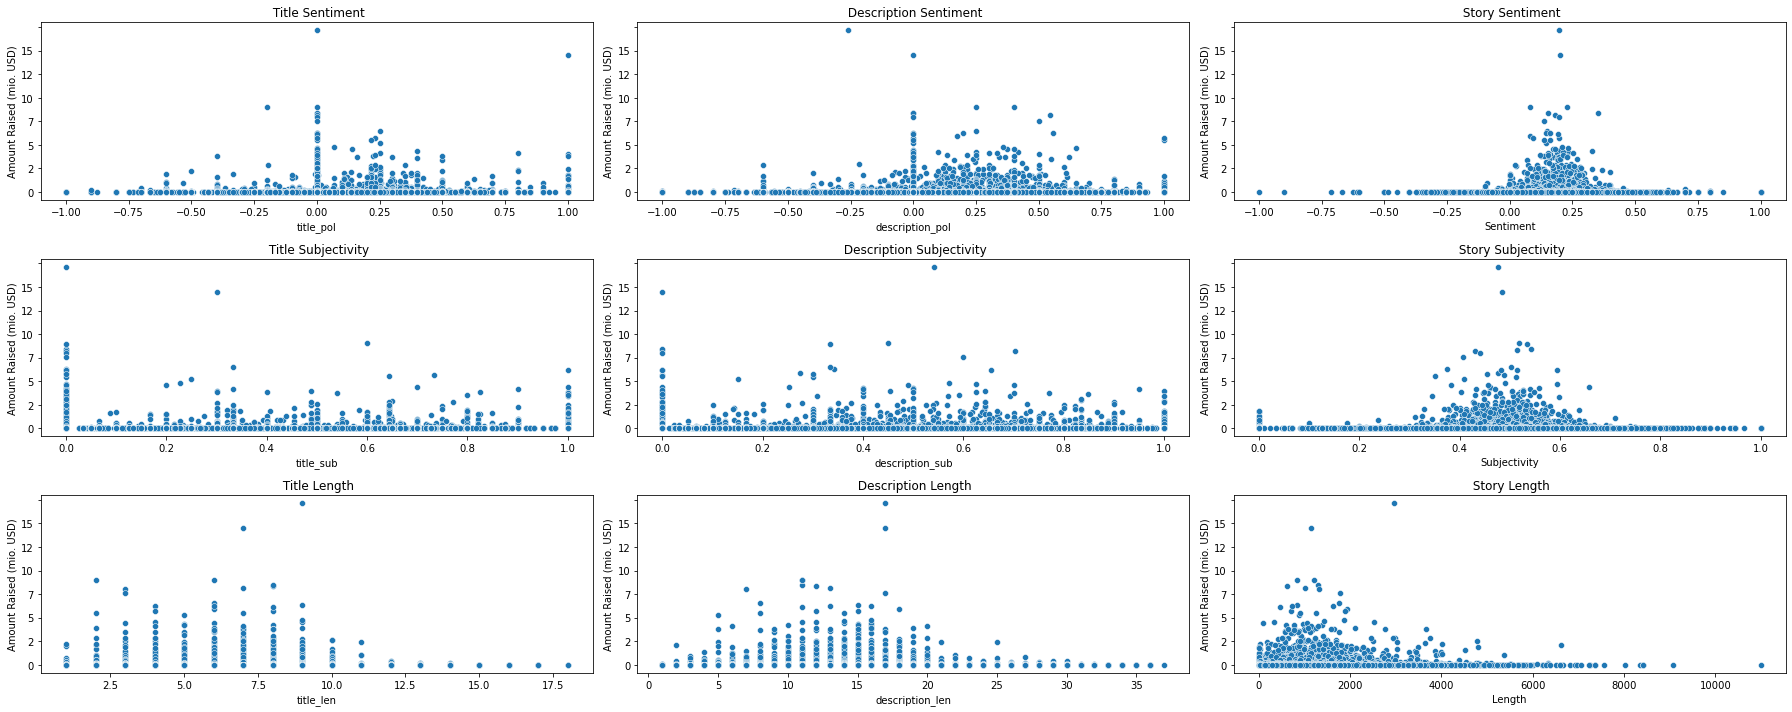

In [36]:
# plot amount raised vs sentiment
fig, axs = plt.subplots(3, 3, figsize=(25,10))
sns.scatterplot(ax=axs[0, 0], x='title_pol', y='fnd_raised', data=data).set_title(' Title Sentiment')
sns.scatterplot(ax=axs[0, 1], x='description_pol', y='fnd_raised', data=data).set_title(' Description Sentiment')
sns.scatterplot(ax=axs[0, 2], x='story_txt_pol', y='fnd_raised', data=data).set_title(' Story Sentiment')
axs[0, 2].set_xlabel('Sentiment')

sns.scatterplot(ax=axs[1, 0], x='title_sub', y='fnd_raised', data=data).set_title(' Title Subjectivity')
sns.scatterplot(ax=axs[1, 1], x='description_sub', y='fnd_raised', data=data).set_title(' Description Subjectivity')
sns.scatterplot(ax=axs[1, 2], x='story_txt_sub', y='fnd_raised', data=data).set_title(' Story Subjectivity')
axs[1, 2].set_xlabel('Subjectivity')

sns.scatterplot(ax=axs[2, 0], x='title_len', y='fnd_raised', data=data).set_title(' Title Length')
sns.scatterplot(ax=axs[2, 1], x='description_len', y='fnd_raised', data=data).set_title(' Description Length')
sns.scatterplot(ax=axs[2, 2], x='story_txt_len', y='fnd_raised', data=data).set_title(' Story Length')
axs[2, 2].set_xlabel('Length')

# convert y labels to millions
for ax in axs.flatten():
    ax.set_ylabel('Amount Raised (mio. USD)')	
    yticks = ax.get_yticks()
    yticks = [int(y/1000000) for y in yticks]
    ax.set_yticklabels(yticks)


plt.tight_layout()
plt.show()

This plots a word cloud for every category and gives insights into the different topics in each category and also sheds light on the quality of the cleaned texts.

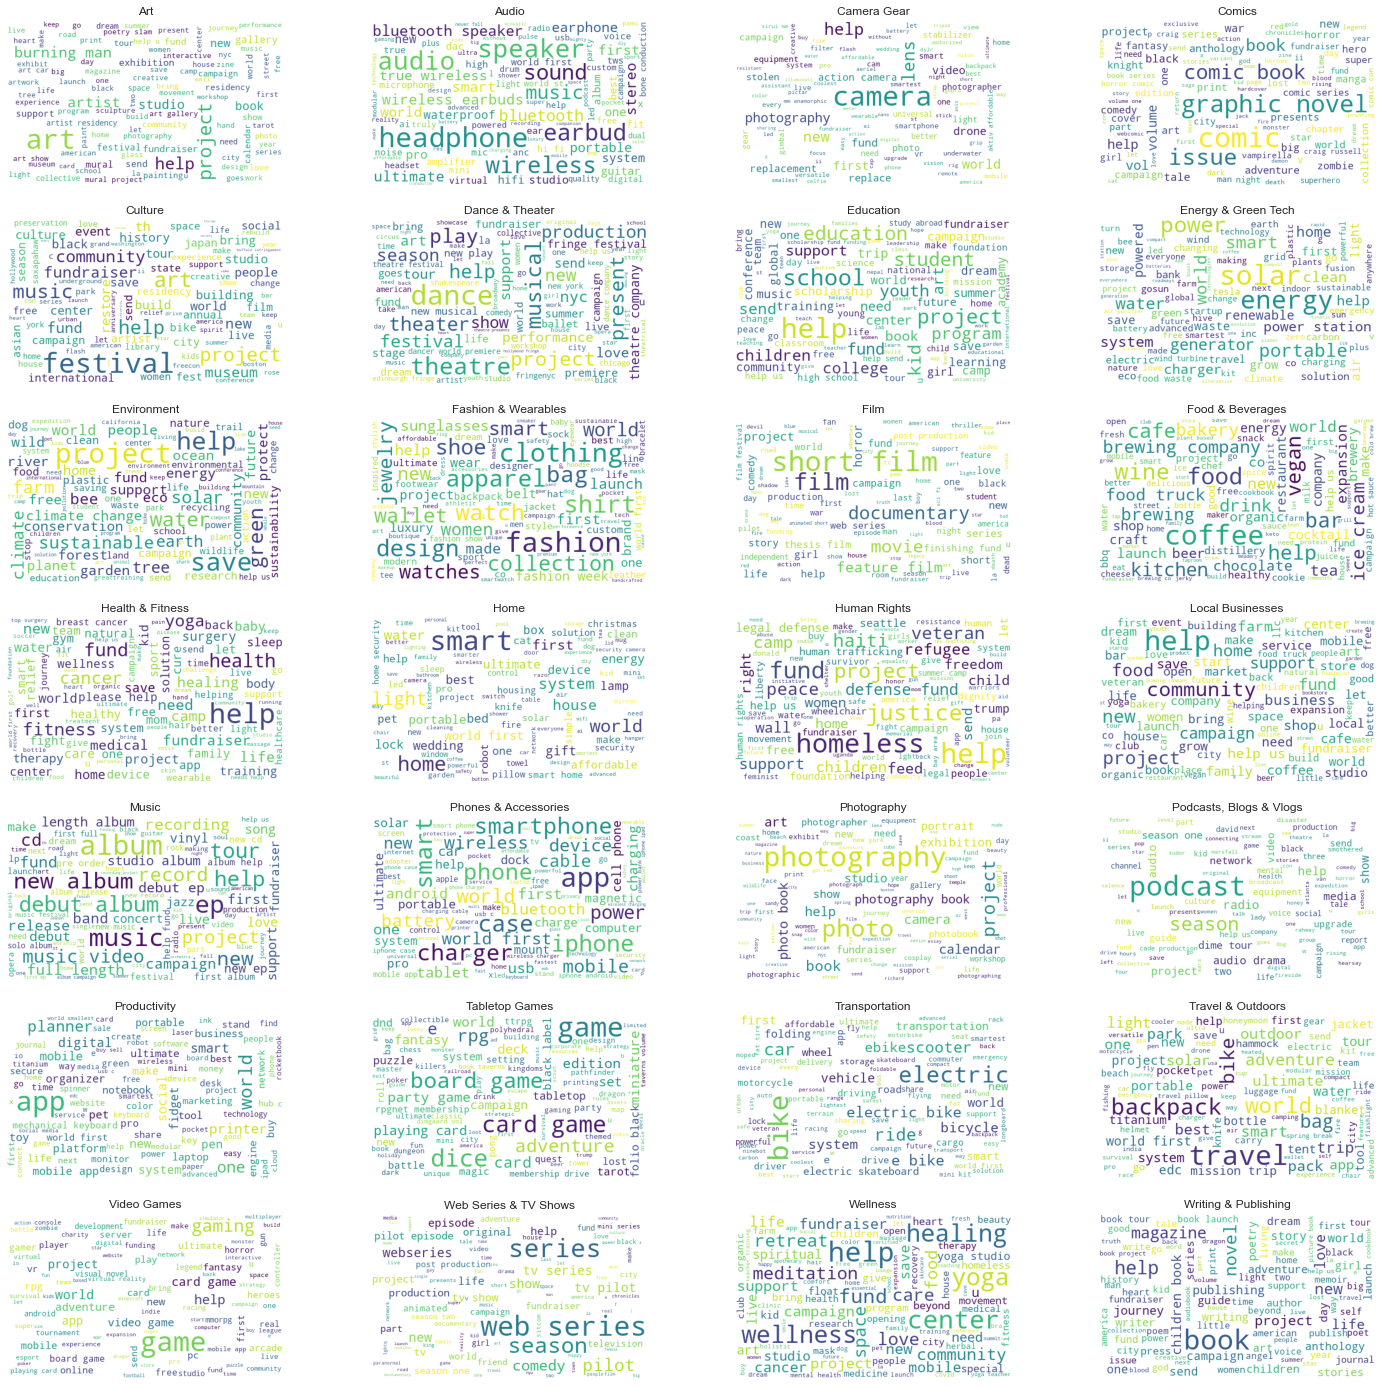

In [50]:
# create wordcloud for each category
fig, axs = plt.subplots(7, 4, figsize=(25, 25))
axs = axs.ravel()

for i, category in enumerate(data.category.unique()):
    # create wordcloud
    wordcloud = WordCloud(background_color='white', width=500, height=300, max_words=100, max_font_size=50).generate(' '.join(data[data.category == category].title_clean))
    # plot wordcloud
    axs[i].imshow(wordcloud)
    axs[i].set_title(category)#
    axs[i].axis('off')
plt.show()